In [1]:
include("construct_lib.jl")
using DynamicPolynomials, MultivariatePolynomials, HomotopyContinuation, JSON

# Constants and Parameters
const d1, d2, ds = 3, 7, 1  # Degree range and step
const n, a, b = 2, 1, 3
const C = a / b  # Scaling constant
const delta, alph = 1 / 2, 9 / 10  # Sampling parameters

(0.5, 0.9)

discrete_l2_norm (generic function with 1 method)

In [27]:
L2 = []
function discrete_l2_norm(P, tref, C)
    # Define the grid
    n = 100
    x_vals = range(-C, C, length=n)
    y_vals = range(-C, C, length=n)

    # Initialize the norm
    norm = 0.0

    # Compute the difference and sum up the squares
    for x_val in x_vals, y_val in y_vals
        P_val = subs(P, x[1] => x_val, x[2] => y_val)
        println(P_val)
        f_val = tref(x_val, y_val)
        diff = P_val - f_val
        norm += diff^2
    end

    # Take the square root and normalize by the grid size
    norm = sqrt(norm / (n * n))

    return norm
end

for (i, d) in enumerate(d1:ds:d2)
    ## Read and parse the files
    file_path_pts = expanduser("data/pts_rat_msolve_d$(d)_C_$(a)_$b.txt")
    file_path_pol = expanduser("data/pol_rat_msolve_d$(d)_C_$(a)_$b.txt")

    # Collect the polynomial
    data_pol = read(file_path_pol, String)
    # Read the polynomial approximant
    polynomial = eval(Meta.parse(data_pol))
    push!(L2, discrete_l2_norm(polynomial, tref, C))

end
println(L2)

MethodError: MethodError: no method matching ^(::Vector{DynamicPolynomials.Variable{DynamicPolynomials.Commutative{DynamicPolynomials.CreationOrder}, Graded{LexOrder}}}, ::Int64)

Closest candidates are:
  ^(!Matched::Union{AbstractChar, AbstractString}, ::Integer)
   @ Base strings/basic.jl:733
  ^(!Matched::Union{Arblib.AcbPoly, Arblib.ArbPoly}, ::Integer)
   @ Arblib ~/.julia/packages/Arblib/ZnCj1/src/poly.jl:602
  ^(!Matched::Union{Arblib.Acb, Arblib.AcbRef}, ::Union{Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, Arblib.Acb, Arblib.AcbRef, Arblib.Arb, Arblib.ArbRef})
   @ Arblib ~/.julia/packages/Arblib/ZnCj1/src/arithmetic.jl:109
  ...


In [2]:
@polyvar(x, y) # Define polynomial ring
array_of_vectors_x = Vector{Vector{Float64}}()
array_of_vectors_y = Vector{Vector{Float64}}()

for (i, d) in enumerate(d1:ds:d2)
    ## Read and parse the files
    file_path_pts = expanduser("data/pts_rat_msolve_d$(d)_C_$(a)_$b.txt")
    file_path_pol = expanduser("data/pol_rat_msolve_d$(d)_C_$(a)_$b.txt")

    # Read points msolve
    data_pts = read(file_path_pts, String)
    trimmed_content = strip(data_pts, ['[', ']']) # trim brackets
    rows = split(trimmed_content, "], [") # split into two arrays
    # Collect the two arrays of msolve points
    data_array = [parse.(Float64, split(strip(row, ['[', ']']), ", ")) for row in rows]

    # Collect the polynomial
    data_pol = read(file_path_pol, String)
    # Read the polynomial approximant
    polynomial = eval(Meta.parse(data_pol))

    # Compute derivatives
    P1 = differentiate(polynomial, x)
    P2 = differentiate(polynomial, y)

    # Compute Homotopy Continuation
    homoto = RR_xy_solve(n, P1, P2)

    # Define the condition for filtering
    condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1

    # Filter points using the filter function
    filtered_points = filter(condition, homoto)
    h_x = [point[1] for point in filtered_points] # for plotting
    h_y = [point[2] for point in filtered_points]
    push!(array_of_vectors_x, h_x)
    push!(array_of_vectors_y, h_y)

end


Computing mixed cells... 2    Time: 0:00:00
Computing mixed cells... 2    Time: 0:00:00
  mixed_volume:  4


Tracking 4 paths...  50%|███████████████▌               |  ETA: 0:00:07



Tracking 4 paths... 100%|███████████████████████████████| Time: 0:00:07
  # paths tracked:                  4
  # non-singular solutions (real):  4 (4)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         4 (4)
Tracking 9 paths...  22%|██████▉                        |  ETA: 0:00:09



Tracking 9 paths... 100%|███████████████████████████████| Time: 0:00:02
  # paths tracked:                  9
  # non-singular solutions (real):  9 (3)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         9 (3)
Tracking 16 paths...  12%|███▊                          |  ETA: 0:00:20



Tracking 16 paths... 100%|██████████████████████████████| Time: 0:00:02
  # paths tracked:                  16
  # non-singular solutions (real):  16 (16)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         16 (16)
Tracking 25 paths...   8%|██▍                           |  ETA

In [3]:
function create_vector_of_pairs(vec1, vec2)
    @assert length(vec1) == length(vec2) "Vectors must be of the same length"
    return collect(zip(vec1, vec2))
end

PTS_pair = create_vector_of_pairs(array_of_vectors_x,array_of_vectors_y)
J = []
for x in PTS_pair
    push!(J, create_vector_of_pairs(x[1], x[2]))
    println(create_vector_of_pairs(x[1], x[2]))
end

[(-0.4344206621044749, 0.4403734627118986), (0.4385571340916686, 0.18798167548269804), (0.40307432025132167, -0.7679718720539117), (-0.5211309029378596, -0.24946483014018794)]
[(-0.44585221688687454, -0.2569907511405553), (-0.3829266250943101, 0.5057061801421926), (0.5021619223487015, 0.19329219797110925)]
[(-0.4100097359965416, 0.16295079647683008), (-0.7914407550545034, -0.754009120738374), (0.6631178125765848, -0.8218307867295999), (-0.7501924568718531, 0.2712054330072547), (0.11194409920033199, 0.6899399993508106), (0.24827735648207974, -0.77256739730462), (0.39501263057205593, -0.15460025379477874), (0.7920670821371054, 0.7265020895833351), (-0.29535553985135093, 0.7660221287044591), (-0.8589935547830967, -0.4233863069057363), (-0.2895250848822145, -0.2662280255211813), (-0.6663921849389721, 0.8077831536322939), (0.738411639395151, -0.2613608906852324), (0.8449712007760811, 0.43797195523623356), (-0.10645961221079621, -0.7077247288256652), (0.2797969784323571, 0.2671079945764104)]

Goal is to have an identification of all local minima and maxima into two arrays of points. This is to be done by evaluating f and then generating a black and white picture, where each pixel is the average change compared to evaluations of f on the direct neighbors.  

In [5]:
using Plots
plotly()  # or gr()

# Define the function and domain

# Generate the grid and evaluate the function
N = 100  # resolution of the grid
x = range(-C, C, length=N)
y = range(-C, C, length=N)
z = [tref(xi, yi) for xi in x, yi in y]



# Create the plot with more contours and smooth transitions
contour(x, y, z, fill=true, color=:viridis,
    xlabel="x", ylabel="y", levels=50, c=:viridis)

┌ Warning: Failed to load integration with PlotlyBase & PlotlyKaleido.
│   exception = (ArgumentError("Package PlotlyKaleido not found in current path.\n- Run `import Pkg; Pkg.add(\"PlotlyKaleido\")` to install the PlotlyKaleido package."), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000074f771f43bfb, Ptr{Nothing} @0x000074f771f43c16, Ptr{Nothing} @0x000074f788642f4d, Ptr{Nothing} @0x000074f78867a338, Ptr{Nothing} @0x000074f78867c1ba, Ptr{Nothing} @0x000074f78865f60a, Ptr{Nothing} @0x000074f7886602e1, Base.InterpreterIP in top-level CodeInfo for Main at statement 1, Ptr{Nothing} @0x000074f78867b22b, Ptr{Nothing} @0x000074f78867cdfa, Ptr{Nothing} @0x000074f6c5dd94dc, Ptr{Nothing} @0x000074f6c5dd9904, Ptr{Nothing} @0x000074f6c5dd99df, Ptr{Nothing} @0x000074f6c5dd99ff, Ptr{Nothing} @0x000074f788642f4d, Ptr{Nothing} @0x000074f78865ed94, Ptr{Nothing} @0x000074f78865e7b7, Ptr{Nothing} @0x000074f78865f405, Ptr{Nothing} @0x000074f7886602e1, Base.InterpreterIP in top-level CodeInfo 

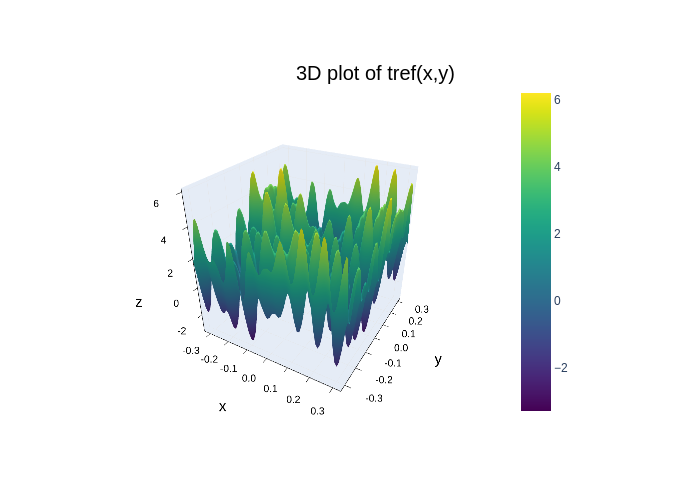

In [6]:
plotlyjs()

plot(x, y, z, st=:surface, title="3D plot of tref(x,y)", xlabel="x", ylabel="y", zlabel="z", color=:viridis)


In [10]:

using Distances
plotlyjs()

# Define the function and domain

# Generate the grid and evaluate the function
N = 50  # resolution of the grid
x = range(-C, C, length=N)
y = range(-C, C, length=N)
z = [tref(xi, yi) for xi in x, yi in y]

# Convert z to a matrix for easier indexing
z_matrix = reshape(z, N, N)

# Function to find local minima and maxima
function find_extrema(z::Array{Float64,2})
    n, m = size(z)
    minima = []
    maxima = []
    for i in 2:n-1
        for j in 2:m-1
            neighborhood = z[i-1:i+1, j-1:j+1]
            center = z[i, j]
            if center == minimum(neighborhood)
                push!(minima, (i, j))
            elseif center == maximum(neighborhood)
                push!(maxima, (i, j))
            end
        end
    end
    return minima, maxima
end

# Find local minima and maxima
minima_indices, maxima_indices = find_extrema(z_matrix)

# Extract the coordinates of the minima and maxima
minima_coords = [(x[i], y[j]) for (i, j) in minima_indices]
maxima_coords = [(x[i], y[j]) for (i, j) in maxima_indices]

# Combine minima and maxima coordinates
extrema_coords = vcat(minima_coords, maxima_coords)

# Compute pairwise distances between all extrema
dist_matrix = pairwise(Euclidean(), extrema_coords)

# Find the minimum non-zero distance
min_dist = minimum(dist_matrix[dist_matrix.>0])

# The smallest radius for disjoint circles is half of the minimum distance
radius = min_dist / 2

# Create the 2D contour plot
contour(x, y, z_matrix, fill=true, color=:viridis, title="Contour plot of tref(x,y) with Minima and Maxima",
    xlabel="x", ylabel="y", levels=30, smooth=true, c=:viridis)

# Plot the minima and maxima points
scatter!(first.(minima_coords), last.(minima_coords), color="blue", marker=:circle, label="Minima")
scatter!(first.(maxima_coords), last.(maxima_coords), color="red", marker=:diamond, label="Maxima")

# Plot circles around each extremum
for coord in extrema_coords
    scatter!([coord[1]], [coord[2]], m=(0.1, :black), label=false)
    plot!([coord[1] .+ radius * cos(θ) for θ in range(0, stop=2pi, length=100)],
        [coord[2] .+ radius * sin(θ) for θ in range(0, stop=2pi, length=100)],
        color=:black, label=false)
end


MethodError: MethodError: no method matching oneunit(::Type{Any})

Closest candidates are:
  oneunit(::Type{Union{Missing, T}}) where T
   @ Base missing.jl:105
  oneunit(::Type{T}) where T
   @ Base number.jl:370
  oneunit(::T) where T
   @ Base number.jl:369
  ...


Generate the discrete L2-norm of the error of $f(x,y)$ and the approximant $p(x, y)$ on a grid of size $100\times 100$